Данный ноутбук содержит работу с правильно размеченными данными.

Прежде чем запускать данный ноутбук, Вам необходимо:
1) Выполнить шаги (2), (3), (4), (5), (6), (11), (12), (13), (14), (15) из Preprocessing.ipynb.
2) Обучить модель Unet для сегментции лёгких и сердца в Segmentation.ipynb.

# Библиотеки

In [1]:
from keras import layers
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from tensorflow import keras
from keras.applications.densenet import DenseNet121
from IPython.display import display
import matplotlib as mpl
from keras.preprocessing import image as keras_image
from keras import models
import keras_cv
from keras import Model
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from tensorflow.keras import backend as keras
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam 
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, BatchNormalization
from skimage import morphology
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
%matplotlib inline
os.environ["KERAS_BACKEND"] = "tensorflow"

2024-08-28 18:13:41.929129: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 18:13:42.695452: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Параметры

In [2]:
# Пути к папкам с изображениями
merge_folder = 'More Bbox Nodule/merge/'
nodule_folder = 'NODE21/dataset_node21/cxr_images/original_data/png_Nodule/'
clean_folder = 'NODE21/dataset_node21/cxr_images/original_data/png_clean/'

IMG_SIZE = 224
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
EPOCHS = 100

SEED = 42

# Функции

'''
Reference
https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
'''

In [3]:
def build_decoder(with_labels=True, target_size=(IMG_SIZE, IMG_SIZE)):
    """
    Создает декодер для изображений.

    Параметры:
    with_labels (bool): Если True, декодер будет возвращать изображения вместе с метками. По умолчанию True.
    target_size (tuple): Размер, до которого будут изменены изображения. По умолчанию (IMG_SIZE, IMG_SIZE).

    Возвращает:
    function: Функция декодирования изображений. Если with_labels=True, возвращает функцию, которая принимает путь к изображению и метку, и возвращает декодированное изображение и метку. Если with_labels=False, возвращает функцию, которая принимает только путь к изображению и возвращает декодированное изображение.
    """
    def decode(path):
        """
        Декодирует изображение из файла.

        Параметры:
        path (str): Путь к файлу изображения.

        Возвращает:
        tf.Tensor: Декодированное изображение.
        """
        file_bytes = tf.io.read_file(path) 
        img = tf.image.decode_png(file_bytes, channels=1) 
        img = tf.cast(img, tf.float32) / 255.0 
        img = tf.image.resize(img, target_size) 
        img = tf.repeat(img, 3, axis=-1)
        return img
    
    def decode_with_labels(path, label):
        """
        Декодирует изображение из файла и возвращает его вместе с меткой.

        Параметры:
        path (str): Путь к файлу изображения.
        label (any): Метка, связанная с изображением.

        Возвращает:
        tuple: Декодированное изображение и метка.
        """
        return decode(path), label
    
    return decode_with_labels if with_labels else decode

In [4]:
def build_augmenter(with_labels=True):
    """
    Создает аугментатор для изображений.

    Параметры:
    with_labels (bool): Если True, аугментатор будет возвращать изображения вместе с метками. По умолчанию True.

    Возвращает:
    function: Функция аугментации изображений. Если with_labels=True, возвращает функцию, которая принимает изображение и метку, и возвращает аугментированное изображение и метку. Если with_labels=False, возвращает функцию, которая принимает только изображение и возвращает аугментированное изображение.
    """
    augmenter = keras_cv.layers.Augmenter(
        [
            keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
            keras_cv.layers.RandomRotation(factor=(-0.04, 0.04), fill_mode="constant", fill_value=0),
        ],
    )
    rotation = keras_cv.layers.RandomRotation(factor=(0.25, 0.25), fill_mode="constant", fill_value=0)

    def augment(inputs):
        """
        Аугментирует входные данные.

        Параметры:
        inputs (dict): Словарь с ключами 'images' и 'labels', где 'images' - это изображения, а 'labels' - метки.

        Возвращает:
        tuple: Аугментированные изображения и метки.
        """
        outputs = inputs
        outputs = augmenter(outputs)
        if tf.random.uniform([]) < 0.5:
            outputs['images'] = rotation(outputs['images'])
        return outputs['images'], outputs['labels']

    def augment_with_labels(img, label):
        """
        Аугментирует изображение и возвращает его вместе с меткой.

        Параметры:
        img (tf.Tensor): Изображение.
        label (any): Метка, связанная с изображением.

        Возвращает:
        tuple: Аугментированное изображение и метка.
        """
        return augment({"images": img, "labels": label})

    return augment_with_labels if with_labels else augment

In [5]:
def build_dataset(paths, labels=None, batch_size=32, decode_fn=None, augment_fn=None, augment=True, repeat=True):
    """
    Создает набор данных для обучения модели.

    Параметры:
    paths (list): Список путей к изображениям.
    labels (list, optional): Список меток, соответствующих изображениям. По умолчанию None.
    batch_size (int): Размер батча. По умолчанию 32.
    decode_fn (function, optional): Функция декодирования изображений. По умолчанию None.
    augment_fn (function, optional): Функция аугментации изображений. По умолчанию None.
    augment (bool): Если True, изображения будут аугментированы. По умолчанию True.
    repeat (bool): Если True, набор данных будет повторяться бесконечно. По умолчанию True.

    Возвращает:
    tf.data.Dataset: Набор данных, готовый для обучения модели.
    """
    if decode_fn is None:
        decode_fn = build_decoder(labels is not None)
    
    if augment_fn is None:
        augment_fn = build_augmenter(labels is not None)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = paths if labels is None else (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    dset = dset.map(decode_fn, num_parallel_calls=AUTO)
    dset = dset.map(augment_fn, num_parallel_calls=AUTO) if augment else dset
    dset = dset.repeat() if repeat else dset
    dset = dset.batch(batch_size).prefetch(AUTO)
    return dset

In [6]:
def plot_loss_metrics(history, metric1, metric2, label1, label2):
    """
    Строит графики метрик обучения и валидации.

    Параметры:
    history (tf.keras.callbacks.History): Объект истории, содержащий данные о метриках обучения и валидации.
    metric1 (str): Название первой метрики для построения графика.
    metric2 (str): Название второй метрики для построения графика.
    label1 (str): Метка для первой метрики.
    label2 (str): Метка для второй метрики.

    Возвращает:
    None
    """
    plt.figure(figsize=(12, 4))
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel(metric1, fontsize=14)
    plt.plot(history.history[metric1], label=f"Training {label1}", marker='o', markersize=6, linewidth=2)
    plt.plot(history.history[f"val_{metric1}"], label=f"Validation {label1}", marker='+', markersize=8, linewidth=2)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

    plt.figure(figsize=(12, 4))
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel(metric2, fontsize=14)
    plt.plot(history.history[metric2], label=f"Training {label2}", marker='o', markersize=6, linewidth=2)
    plt.plot(history.history[f"val_{metric2}"], label=f"Validation {label2}", marker='+', markersize=8, linewidth=2)
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

In [7]:
def plot_roc_auc(model_name, valid_data, valid_labels):
    """
    Строит графики ROC-AUC для каждой категории и выводит AUC для каждой категории.

    Параметры:
    model_name (str): Имя файла модели, которую нужно загрузить.
    valid_data (numpy.ndarray): Данные для валидации.
    valid_labels (numpy.ndarray): Метки для валидации.
    metadata (pandas.DataFrame): Метаданные, содержащие названия категорий.

    Возвращает:
    None
    """
    tf.keras.backend.clear_session()

    model = tf.keras.models.load_model(model_name)
    pred = model.predict(valid_data, verbose=1)

    print('AUC для Nodule/Mass')
    print(roc_auc_score(valid_labels, pred))

    fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))
    fpr, tpr, thresholds = roc_curve(valid_labels, pred)
    c_ax.plot(fpr, tpr, label='Nodule/Mass(AUC:%0.2f)' % roc_auc_score(valid_labels, pred))
    c_ax.legend(fontsize=12)
    c_ax.set_xlabel('False Positive Rate', fontsize=14)
    c_ax.set_ylabel('True Positive Rate', fontsize=14)
    c_ax.tick_params(axis='both', which='major', labelsize=12)
    fig.savefig(model_name[:-5] + 'png')
    plt.show()

# Предобработка данных

In [8]:
paths = []
nodule_mass_labels = []

def add_images_from_folder(folder_path, label):
    for image_name in os.listdir(folder_path):
        paths.append(os.path.join(folder_path, image_name))
        nodule_mass_labels.append(label)

add_images_from_folder(merge_folder, 1)
add_images_from_folder(nodule_folder, 1)
add_images_from_folder(clean_folder, 0)

# Создание DataFrame с путями и метками
df = pd.DataFrame({
    'path': paths,
    'Nodule/Mass': nodule_mass_labels
})

df

path  Nodule/Mass
0               More Bbox Nodule/merge/00019001_000.png            1
1               More Bbox Nodule/merge/00020405_021.png            1
2               More Bbox Nodule/merge/00019124_067.png            1
3               More Bbox Nodule/merge/00004001_013.png            1
4               More Bbox Nodule/merge/00026606_000.png            1
...                                                 ...          ...
6527  NODE21/dataset_node21/cxr_images/original_data...            0
6528  NODE21/dataset_node21/cxr_images/original_data...            0
6529  NODE21/dataset_node21/cxr_images/original_data...            0
6530  NODE21/dataset_node21/cxr_images/original_data...            0
6531  NODE21/dataset_node21/cxr_images/original_data...            0

[6532 rows x 2 columns]

In [9]:
# Создадим колонку с id пациента
df['patient_id'] = df['path'].str.extract(r'(\d+)_\d+\.png')
df['patient_id'] = df['patient_id'].fillna(df['path'])

In [10]:
# Выведем количество изображений для пациентов
image_counts = df.groupby('patient_id').size().reset_index(name='image_count')
image_counts_sorted = image_counts.sort_values(by='image_count', ascending=False)
image_counts_sorted

patient_id  image_count
979                                            00019124           40
1076                                           00020703           16
992                                            00019373           13
968                                            00018964           11
1193                                           00023033           10
...                                                 ...          ...
2162  NODE21/dataset_node21/cxr_images/original_data...            1
2161  NODE21/dataset_node21/cxr_images/original_data...            1
2160  NODE21/dataset_node21/cxr_images/original_data...            1
2159  NODE21/dataset_node21/cxr_images/original_data...            1
5736  NODE21/dataset_node21/cxr_images/original_data...            1

[5737 rows x 2 columns]

In [11]:
# Группируем по 'patient_id' и выбираем первое изображение для каждого пациента
df = df.groupby('patient_id').first().reset_index()

In [12]:
# Разделение данных на тренировочные и валидационные наборы
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

train_paths = train_df['path']
valid_paths = valid_df['path']
train_labels = train_df['Nodule/Mass']
valid_labels = valid_df['Nodule/Mass']

print(f'Количество тренировочных изображений: {len(train_paths)}')
print(f'Количество валидационных изображений: {len(valid_paths)}')

Количество тренировочных изображений: 4589
Количество валидационных изображений: 1148


In [13]:
# Подсчет количества изображений с метками 1 и 0 в тренировочной выборке
train_counts = train_df['Nodule/Mass'].value_counts()
print(f'В тренировочной выборке изображений с меткой 1: {train_counts[1]}')
print(f'В тренировочной выборке изображений с меткой 0: {train_counts[0]}')

# Подсчет количества изображений с метками 1 и 0 в валидационной выборке
valid_counts = valid_df['Nodule/Mass'].value_counts()
print(f'В валидационной выборке изображений с меткой 1: {valid_counts[1]}')
print(f'В валидационной выборке изображений с меткой 0: {valid_counts[0]}')

В тренировочной выборке изображений с меткой 1: 1570
В тренировочной выборке изображений с меткой 0: 3019
В валидационной выборке изображений с меткой 1: 419
В валидационной выборке изображений с меткой 0: 729


Код ниже пригодится для сравнения моделей обученных на разных данных в Сomparison_of_data.ipynb.

In [14]:
valid_df.to_csv('valid_df.csv', index=False)

In [15]:
train_df = train_df.sort_values(by='patient_id')
train_df_filtered = train_df[train_df['patient_id'].str.match(r'^\d{8}$')]
train_df_filtered.to_csv('train_patient.csv', index=False)

In [16]:
valid_df = valid_df.sort_values(by='patient_id')
valid_df_filtered = valid_df[valid_df['patient_id'].str.match(r'^\d{8}$')]
valid_df_filtered.to_csv('valid_patient.csv', index=False)

# Обучение модели

In [14]:
name = 'Correctly_data_model.keras'

decoder = build_decoder(with_labels=True, target_size=(IMG_SIZE, IMG_SIZE))
dtrain = build_dataset(train_paths, train_labels, batch_size=BATCH_SIZE, decode_fn=decoder, augment=True, repeat=True)
dvalid = build_dataset(valid_paths, valid_labels, batch_size=BATCH_SIZE, decode_fn=decoder, augment=False, repeat=False)

2024-08-27 19:06:04.073457: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-27 19:06:04.074419: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-27 19:06:04.074574: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2024-08-27 19:06:05.294084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


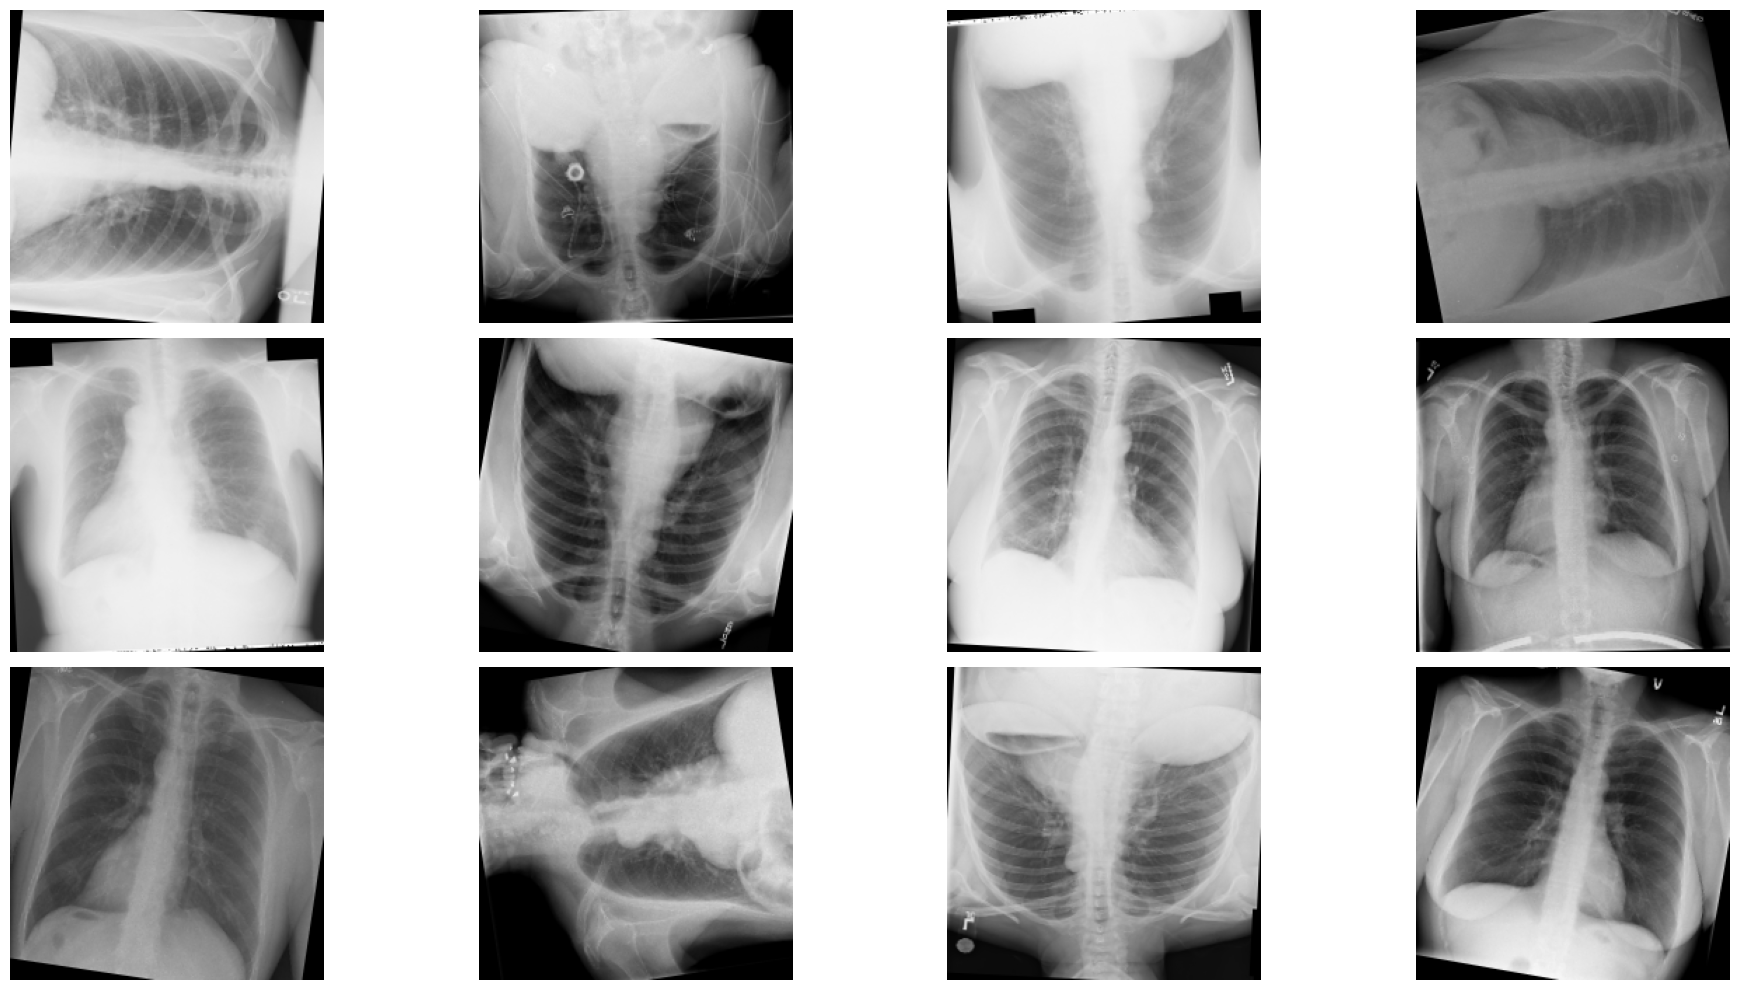

In [15]:
data, _ = dtrain.take(2)
images = data[0].numpy()
fig, axes = plt.subplots(3, 4, figsize=(20,10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [16]:
# Рассчитаем веса для классов, ибо у нас присутствует дисбаланс
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_labels),
                                                  y=train_labels)

class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.7600198741305068, 1: 1.4614649681528662}

In [17]:
def build_model():
    base_model = DenseNet121(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    attention = layers.Dense(1024, activation='relu')(x)
    attention = layers.Dense(1024, activation='sigmoid')(attention)
    x = layers.Multiply()([x, attention])

    x = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs=base_model.input, outputs=x)

model = build_model()
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=loss, metrics=[tf.keras.metrics.AUC()])

In [18]:
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, verbose = 1, min_delta = 1e-4, min_lr = 1e-7, mode = 'min', cooldown=1)
ckp = ModelCheckpoint(name, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 11, mode = 'min', restore_best_weights = True, verbose = 1)

callbacks_list = [rlr, ckp, es]
history = model.fit(dtrain,
                    validation_data=dvalid,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    steps_per_epoch=train_paths.shape[0]//BATCH_SIZE,
                    verbose=1,
                    class_weight=class_weights)

Epoch 1/100


I0000 00:00:1724760406.014606   12913 service.cc:145] XLA service 0x7f7cf00022c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724760406.014636   12913 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-08-27 19:06:48.368301: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-27 19:06:53.615205: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1724760417.379334   12992 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_32682', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1724760417.475418   12989 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_32682', 32 bytes spill stores, 32 bytes spill loads

I0000

 43/143 ━━━━━━━━━━━━━━━━━━━━ 20s 207ms/step - auc: 0.6957 - loss: 0.6338

2024-08-27 19:08:25.495171: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - auc: 0.7578 - loss: 0.5818

I0000 00:00:1724760545.890776   13147 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3311', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1724760546.602799   13145 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3304', 240 bytes spill stores, 240 bytes spill loads




Epoch 1: val_loss improved from inf to 0.57769, saving model to Correctly_data_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 189s 428ms/step - auc: 0.7581 - loss: 0.5815 - val_auc: 0.7496 - val_loss: 0.5777 - learning_rate: 1.0000e-04
Epoch 2/100
 43/143 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - auc: 0.8337 - loss: 0.5024

2024-08-27 19:09:26.859394: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - auc: 0.8395 - loss: 0.4945
Epoch 2: val_loss did not improve from 0.57769
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 286ms/step - auc: 0.8395 - loss: 0.4944 - val_auc: 0.8084 - val_loss: 1.1167 - learning_rate: 1.0000e-04
Epoch 3/100
 43/143 ━━━━━━━━━━━━━━━━━━━━ 17s 180ms/step - auc: 0.8527 - loss: 0.4759

2024-08-27 19:10:06.232661: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - auc: 0.8614 - loss: 0.4615
Epoch 3: val_loss improved from 0.57769 to 0.45222, saving model to Correctly_data_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 289ms/step - auc: 0.8614 - loss: 0.4614 - val_auc: 0.8579 - val_loss: 0.4522 - learning_rate: 1.0000e-04
Epoch 4/100
 36/143 ━━━━━━━━━━━━━━━━━━━━ 16s 156ms/step - auc: 0.8504 - loss: 0.4831

2024-08-27 19:10:45.141955: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - auc: 0.8694 - loss: 0.4492
Epoch 4: val_loss did not improve from 0.45222
143/143 ━━━━━━━━━━━━━━━━━━━━ 38s 266ms/step - auc: 0.8695 - loss: 0.4490 - val_auc: 0.8603 - val_loss: 0.5849 - learning_rate: 1.0000e-04
Epoch 5/100
 44/143 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - auc: 0.8848 - loss: 0.4256

2024-08-27 19:11:24.906361: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - auc: 0.8918 - loss: 0.4127
Epoch 5: val_loss improved from 0.45222 to 0.41547, saving model to Correctly_data_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 44s 309ms/step - auc: 0.8918 - loss: 0.4126 - val_auc: 0.8723 - val_loss: 0.4155 - learning_rate: 1.0000e-04
Epoch 6/100
 13/143 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - auc: 0.8843 - loss: 0.4412

2024-08-27 19:12:03.500339: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - auc: 0.8987 - loss: 0.4020
Epoch 6: val_loss did not improve from 0.41547
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 243ms/step - auc: 0.8988 - loss: 0.4019 - val_auc: 0.8803 - val_loss: 0.4371 - learning_rate: 1.0000e-04
Epoch 7/100
 45/143 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - auc: 0.8956 - loss: 0.4119

2024-08-27 19:12:43.644378: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - auc: 0.9084 - loss: 0.3829
Epoch 7: val_loss did not improve from 0.41547
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 273ms/step - auc: 0.9085 - loss: 0.3828 - val_auc: 0.8839 - val_loss: 0.4717 - learning_rate: 1.0000e-04
Epoch 8/100
 45/143 ━━━━━━━━━━━━━━━━━━━━ 16s 166ms/step - auc: 0.9144 - loss: 0.3751

2024-08-27 19:13:22.688047: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - auc: 0.9210 - loss: 0.3570
Epoch 8: val_loss did not improve from 0.41547
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 274ms/step - auc: 0.9210 - loss: 0.3569 - val_auc: 0.8728 - val_loss: 0.5375 - learning_rate: 1.0000e-04
Epoch 9/100
 46/143 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - auc: 0.9090 - loss: 0.3838

2024-08-27 19:14:01.968454: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - auc: 0.9205 - loss: 0.3565
Epoch 9: val_loss improved from 0.41547 to 0.39643, saving model to Correctly_data_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 44s 311ms/step - auc: 0.9205 - loss: 0.3564 - val_auc: 0.8873 - val_loss: 0.3964 - learning_rate: 1.0000e-04
Epoch 10/100
 14/143 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - auc: 0.9158 - loss: 0.3623

2024-08-27 19:14:40.771646: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - auc: 0.9302 - loss: 0.3370
Epoch 10: val_loss did not improve from 0.39643
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 242ms/step - auc: 0.9303 - loss: 0.3369 - val_auc: 0.8868 - val_loss: 0.4025 - learning_rate: 1.0000e-04
Epoch 11/100
 47/143 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - auc: 0.9309 - loss: 0.3358

2024-08-27 19:15:21.005324: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - auc: 0.9370 - loss: 0.3204
Epoch 11: val_loss did not improve from 0.39643
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 275ms/step - auc: 0.9370 - loss: 0.3203 - val_auc: 0.8458 - val_loss: 0.6919 - learning_rate: 1.0000e-04
Epoch 12/100
 47/143 ━━━━━━━━━━━━━━━━━━━━ 17s 179ms/step - auc: 0.9374 - loss: 0.3246

2024-08-27 19:16:00.739760: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - auc: 0.9400 - loss: 0.3140
Epoch 12: val_loss did not improve from 0.39643
143/143 ━━━━━━━━━━━━━━━━━━━━ 43s 300ms/step - auc: 0.9400 - loss: 0.3139 - val_auc: 0.8818 - val_loss: 0.4394 - learning_rate: 1.0000e-04
Epoch 13/100
 27/143 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - auc: 0.9412 - loss: 0.3108

2024-08-27 19:16:39.270818: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - auc: 0.9468 - loss: 0.2947
Epoch 13: val_loss did not improve from 0.39643
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 252ms/step - auc: 0.9469 - loss: 0.2947 - val_auc: 0.8960 - val_loss: 0.3967 - learning_rate: 1.0000e-04
Epoch 14/100
 48/143 ━━━━━━━━━━━━━━━━━━━━ 17s 185ms/step - auc: 0.9453 - loss: 0.2985

2024-08-27 19:17:19.892837: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - auc: 0.9506 - loss: 0.2835
Epoch 14: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 14: val_loss did not improve from 0.39643
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 276ms/step - auc: 0.9507 - loss: 0.2834 - val_auc: 0.8879 - val_loss: 0.5116 - learning_rate: 1.0000e-04
Epoch 15/100
 49/143 ━━━━━━━━━━━━━━━━━━━━ 16s 174ms/step - auc: 0.9562 - loss: 0.2705

2024-08-27 19:17:58.797062: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - auc: 0.9599 - loss: 0.2582
Epoch 15: val_loss improved from 0.39643 to 0.36249, saving model to Correctly_data_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 285ms/step - auc: 0.9599 - loss: 0.2581 - val_auc: 0.9151 - val_loss: 0.3625 - learning_rate: 1.0000e-05
Epoch 16/100
 44/143 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - auc: 0.9739 - loss: 0.2205

2024-08-27 19:18:37.731728: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - auc: 0.9726 - loss: 0.2200
Epoch 16: val_loss did not improve from 0.36249
143/143 ━━━━━━━━━━━━━━━━━━━━ 41s 287ms/step - auc: 0.9726 - loss: 0.2200 - val_auc: 0.9095 - val_loss: 0.3863 - learning_rate: 1.0000e-05
Epoch 17/100
 31/143 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - auc: 0.9675 - loss: 0.2306

2024-08-27 19:19:16.566044: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - auc: 0.9690 - loss: 0.2269
Epoch 17: val_loss did not improve from 0.36249
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 276ms/step - auc: 0.9690 - loss: 0.2268 - val_auc: 0.9161 - val_loss: 0.3704 - learning_rate: 1.0000e-05
Epoch 18/100
 33/143 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - auc: 0.9767 - loss: 0.2032

2024-08-27 19:19:56.182478: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - auc: 0.9740 - loss: 0.2107
Epoch 18: val_loss did not improve from 0.36249
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 276ms/step - auc: 0.9740 - loss: 0.2106 - val_auc: 0.9112 - val_loss: 0.3881 - learning_rate: 1.0000e-05
Epoch 19/100
 33/143 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - auc: 0.9777 - loss: 0.1984

2024-08-27 19:20:35.561495: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - auc: 0.9790 - loss: 0.1922
Epoch 19: val_loss did not improve from 0.36249
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 275ms/step - auc: 0.9790 - loss: 0.1921 - val_auc: 0.9166 - val_loss: 0.3839 - learning_rate: 1.0000e-05
Epoch 20/100
 30/143 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - auc: 0.9774 - loss: 0.2009

2024-08-27 19:21:14.477839: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - auc: 0.9773 - loss: 0.1985
Epoch 20: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 20: val_loss did not improve from 0.36249
143/143 ━━━━━━━━━━━━━━━━━━━━ 35s 247ms/step - auc: 0.9773 - loss: 0.1984 - val_auc: 0.9084 - val_loss: 0.4236 - learning_rate: 1.0000e-05
Epoch 21/100
 51/143 ━━━━━━━━━━━━━━━━━━━━ 16s 184ms/step - auc: 0.9802 - loss: 0.1891

2024-08-27 19:21:54.198155: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - auc: 0.9808 - loss: 0.1845
Epoch 21: val_loss did not improve from 0.36249
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 278ms/step - auc: 0.9808 - loss: 0.1845 - val_auc: 0.9118 - val_loss: 0.4050 - learning_rate: 1.0000e-06
Epoch 22/100
 51/143 ━━━━━━━━━━━━━━━━━━━━ 16s 178ms/step - auc: 0.9809 - loss: 0.1816

2024-08-27 19:22:33.655296: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - auc: 0.9807 - loss: 0.1826
Epoch 22: val_loss did not improve from 0.36249
143/143 ━━━━━━━━━━━━━━━━━━━━ 42s 298ms/step - auc: 0.9807 - loss: 0.1826 - val_auc: 0.9126 - val_loss: 0.4015 - learning_rate: 1.0000e-06
Epoch 23/100
 33/143 ━━━━━━━━━━━━━━━━━━━━ 17s 159ms/step - auc: 0.9813 - loss: 0.1814

2024-08-27 19:23:12.218143: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - auc: 0.9790 - loss: 0.1895
Epoch 23: val_loss did not improve from 0.36249
143/143 ━━━━━━━━━━━━━━━━━━━━ 36s 250ms/step - auc: 0.9790 - loss: 0.1895 - val_auc: 0.9129 - val_loss: 0.4016 - learning_rate: 1.0000e-06
Epoch 24/100
 52/143 ━━━━━━━━━━━━━━━━━━━━ 17s 189ms/step - auc: 0.9780 - loss: 0.1930

2024-08-27 19:23:52.460568: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - auc: 0.9800 - loss: 0.1847
Epoch 24: val_loss did not improve from 0.36249
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 276ms/step - auc: 0.9800 - loss: 0.1846 - val_auc: 0.9136 - val_loss: 0.4016 - learning_rate: 1.0000e-06
Epoch 25/100
 53/143 ━━━━━━━━━━━━━━━━━━━━ 16s 184ms/step - auc: 0.9830 - loss: 0.1788

2024-08-27 19:24:31.678471: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - auc: 0.9825 - loss: 0.1780
Epoch 25: ReduceLROnPlateau reducing learning rate to 1e-07.

Epoch 25: val_loss did not improve from 0.36249
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 275ms/step - auc: 0.9825 - loss: 0.1780 - val_auc: 0.9134 - val_loss: 0.3949 - learning_rate: 1.0000e-06
Epoch 26/100
 53/143 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - auc: 0.9834 - loss: 0.1729

2024-08-27 19:25:10.856354: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - auc: 0.9835 - loss: 0.1721
Epoch 26: val_loss did not improve from 0.36249
143/143 ━━━━━━━━━━━━━━━━━━━━ 39s 273ms/step - auc: 0.9835 - loss: 0.1720 - val_auc: 0.9137 - val_loss: 0.3935 - learning_rate: 1.0000e-07
Epoch 26: early stopping
Restoring model weights from the end of the best epoch: 15.


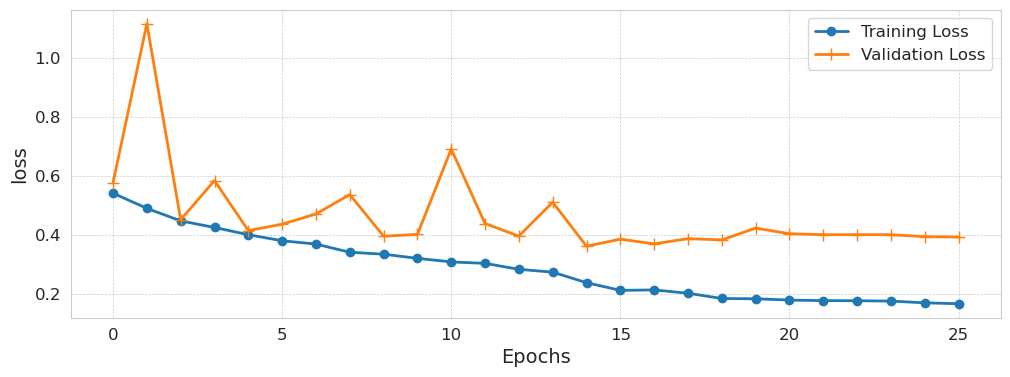

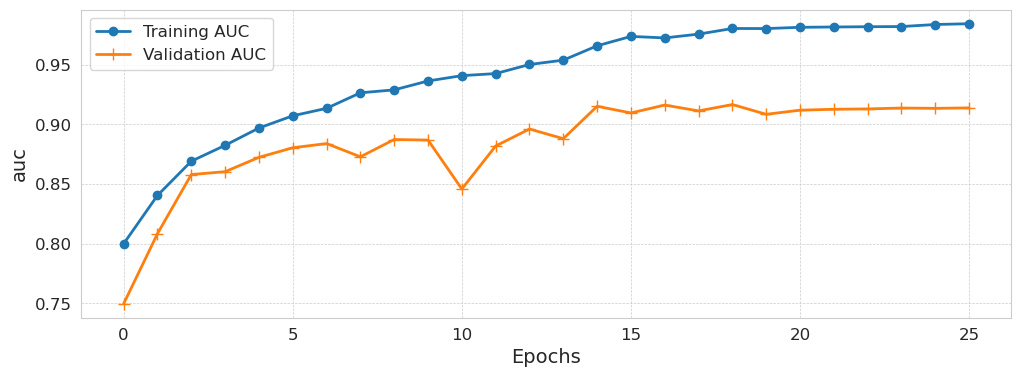

In [19]:
plot_loss_metrics(history, "loss", "auc", "Loss", "AUC")

36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 263ms/step
AUC для Nodule/Mass
0.9156755093288285


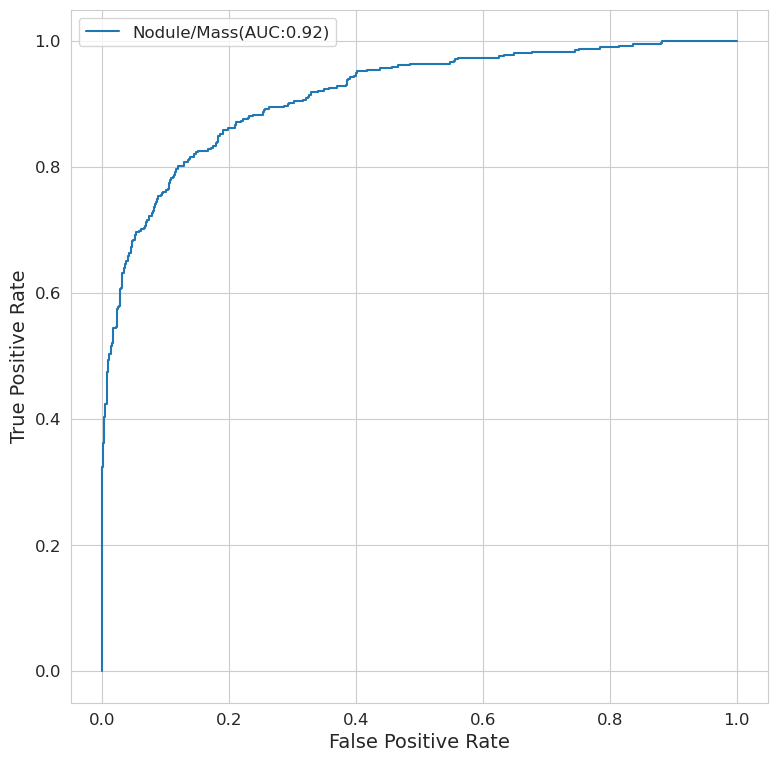

In [23]:
plot_roc_auc(name, dvalid, valid_labels)

# Сегментация 

Код ниже:
1. Загружает модель для сегментации лёгких и сердца
2. Сегментирует снимки для обучения классификатора
3. Дорабатывает маску и сохраняет полученное изображение

In [17]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [18]:
def Unet(input_size=(224, 224, 1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = UpSampling2D(size=(2,2))(conv5)
    merge6 = concatenate([conv4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = UpSampling2D(size=(2,2))(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = UpSampling2D(size=(2,2))(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = UpSampling2D(size=(2,2))(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    
    return model

In [19]:
def apply_clahe(image):
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(4,4))
    return clahe.apply(image)

In [20]:
def extend_mask_to_bottom(mask):
    extended_mask = np.copy(mask)
    for col in range(mask.shape[1]):
        non_zero_indices = np.where(mask[:, col] > 0)[0]
        if len(non_zero_indices) > 0:
            bottom_index = non_zero_indices[-1]
            extended_mask[bottom_index:, col] = 1
    return extended_mask

In [21]:
name = 'Segmentation-Unet-224-full.keras'
model = Unet(input_size=(IMG_SIZE, IMG_SIZE, 1))
model.load_weights(name)

2024-08-28 16:52:39.927144: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-28 16:52:39.930485: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-28 16:52:39.930637: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [22]:
def find_black_col(mask):
    center = mask.shape[1] // 2
    for offset in range(mask.shape[1] // 2 + 1):
        right_col = center + offset
        if right_col < mask.shape[1] and not np.any(mask[:, right_col]):
            return right_col
        left_col = center - offset
        if left_col >= 0 and not np.any(mask[:, left_col]):
            return left_col
    return -1

def find_right_col_with_white(mask, start_col):
    for col in range(start_col + 1, mask.shape[1]):
        if np.any(mask[:, col] != 0):
            return col
    return -1

def find_left_col_with_white(mask, start_col):
    for col in range(start_col - 1, -1, -1):
        if np.any(mask[:, col] != 0):
            return col
    return -1

In [23]:
for i, path in enumerate(train_paths, start=1):
    
    filename = os.path.basename(path)
    
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = apply_clahe(img)
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)

    pred_mask = model.predict(img)
    binary_mask = np.squeeze(pred_mask) >= 0.5
    min_size = 3000
    cleaned_mask = morphology.remove_small_objects(binary_mask, min_size=min_size)

    # Находим местоположение позвоночника
    black_col = find_black_col(cleaned_mask)
    if black_col != -1:
        right_col = find_right_col_with_white(cleaned_mask, black_col)
        left_col = find_left_col_with_white(cleaned_mask, black_col)

    # Применяем dilate к маске лёгких
    kernel = np.ones((20, 20), np.uint8)
    dilated_mask = cv2.dilate(cleaned_mask.astype(np.uint8), kernel, iterations=1)

    # Расширяем маску вниз
    extended_mask = extend_mask_to_bottom(dilated_mask)

    # Удаляем позвоночник из маски
    if black_col != -1 and right_col != -1 and left_col != -1:
        extended_mask[:, left_col:right_col + 1] = 0

    extended_mask_resized = cv2.resize(extended_mask, (img.shape[2], img.shape[1]))

    masked_image = np.copy(np.squeeze(img))
    masked_image[extended_mask_resized == 0] = 0
    background_color = -1
    masked_image[extended_mask_resized == 0] = background_color
    
    cv2.imwrite(f'2k_TRAIN_SEGMENT_BLACK_DEL/{filename}', (masked_image * 255.0).astype(np.uint8))

I0000 00:00:1724838813.385185    3802 service.cc:145] XLA service 0x7f716c01e600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724838813.385225    3802 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-08-28 16:53:33.443275: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-28 16:53:33.600132: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


I0000 00:00:1724838815.193343    3802 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━

libpng warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

Код ниже позволяет сохранить бинарные маски Bbox для изображений которые содержат Nodule/Mass и рассчитать процент попадания в сегментированную часть.

In [24]:
folder1 = "NODE21/dataset_node21/cxr_images/original_data/png_mask/"
folder2 = "More Bbox Nodule/CXR.v1-chestx-ray_zhangjin_kaggle.tensorflow/png_mask/"

output_folder = "png_mask/"

files1 = os.listdir(folder1)
files2 = os.listdir(folder2)

for file in files2:
    if file in files1:
        mask1 = Image.open(os.path.join(folder1, file)).convert('L')
        mask2 = Image.open(os.path.join(folder2, file)).convert('L')
        mask2 = mask2.transpose(Image.FLIP_LEFT_RIGHT)
        final_mask = Image.fromarray(np.bitwise_or(np.array(mask1), np.array(mask2)))
        final_mask.save(os.path.join(output_folder, file))
    else:
        mask = Image.open(os.path.join(folder2, file))
        mask.save(os.path.join(output_folder, file))

for file in files1:
    if file not in files2:
        mask = Image.open(os.path.join(folder1, file))
        mask.save(os.path.join(output_folder, file))

In [25]:
img_dir = '2k_TRAIN_SEGMENT_BLACK_DEL/'
mask_dir = 'png_mask/'

img_files = sorted(os.listdir(img_dir))
mask_files = sorted(os.listdir(mask_dir))

df = pd.DataFrame(columns=['filename', 'percentage'])

for img_file in img_files:
    if img_file in mask_files:
        img = cv2.imread(os.path.join(img_dir, img_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(os.path.join(mask_dir, img_file), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
        _, binary_img = cv2.threshold(img, 1, 255, cv2.THRESH_BINARY)
        white_pixels_binary = cv2.countNonZero(binary_img)
        white_pixels_mask = cv2.countNonZero(mask)
        intersection = cv2.countNonZero(cv2.bitwise_and(binary_img, mask))
        percentage = (intersection / white_pixels_mask) * 100 if white_pixels_mask != 0 else 0
        df = pd.concat([df, pd.DataFrame({'filename': [img_file], 'percentage': [percentage]})], ignore_index=True)

df.to_csv('percentages.csv', index=False)

In [32]:
# Выбор всех записей, где 'percentage' не равен 100
filtered_df = df.loc[df['percentage'] != 100]
filtered_df.sort_values(ascending=True, by=['percentage'])

filename  percentage
962                                    00025248_000.png   35.714286
960                                    00025234_003.png   45.054945
689                                    00017423_001.png   49.479167
284                                    00006699_004.png   55.495772
1521                                       JPCLN093.png   64.062500
17                                     00000224_001.png   71.468337
883                                    00021609_006.png   74.324324
1399                              2642_IM-1128-1001.png   75.000000
54                                     00001167_000.png   79.150579
969                                    00025437_000.png   80.000000
1248  216840111366964012558082906712009313144348306_...   81.818182
202                                    00005109_000.png   84.984359
1136                                   00029863_022.png   89.692436
1097                                   00028642_000.png   93.251834
213                                    00005294_000.png   94.635019
1133                                   00029820_003.png   95.683453
765                                    00019056_004.png   97.280453
940                                    00023145_000.png   97.384094
958                                    00025206_002.png   97.417894
983                                    00025635_008.png   97.690387
168                                    00004214_000.png   98.137803
124                                    00003300_006.png   98.378021
456                                    00012045_049.png   98.423358
360                                    00008947_001.png   98.729447
8                                      00000093_001.png   98.910576
678                                    00017243_010.png   98.962963
247                                    00005918_000.png   99.020979
874                                    00021377_000.png   99.137001
96                                     00002477_001.png   99.348298
135                                    00003519_001.png   99.507129
223                                    00005506_001.png   99.510086
254                                    00006010_000.png   99.544370
504                                    00013499_000.png   99.595653
1086                                   00028442_000.png   99.629468
743                                    00018645_000.png   99.803150
891                                    00021940_000.png   99.810247
818                                    00020195_014.png   99.823477
277                                    00006558_000.png   99.844012
715                                    00018006_024.png   99.918234
842                                    00020611_001.png   99.922420
945                                    00023225_000.png   99.943327
976                                    00025505_000.png   99.958506
664                                    00017028_000.png   99.959904

После анализа полученных сегментированных снимков, было решено для следующих снимков разметить в ручную:
1) 00025248_000.png
2) 00025234_003.png
3) JPCLN093.png

## Обучение модели только на сегментировнных снимках

In [14]:
train_paths = train_df['path']
train_paths = train_paths.apply(lambda x: '2k_TRAIN_SEGMENT_BLACK_DEL/' + x.split('/')[-1])
train_paths 

61      2k_TRAIN_SEGMENT_BLACK_DEL/00000999_000.png
1235    2k_TRAIN_SEGMENT_BLACK_DEL/00025342_007.png
3834           2k_TRAIN_SEGMENT_BLACK_DEL/c1915.png
3729           2k_TRAIN_SEGMENT_BLACK_DEL/c1806.png
1862        2k_TRAIN_SEGMENT_BLACK_DEL/JPCLN025.png
                           ...                     
3772           2k_TRAIN_SEGMENT_BLACK_DEL/c1850.png
5191           2k_TRAIN_SEGMENT_BLACK_DEL/c3323.png
5226           2k_TRAIN_SEGMENT_BLACK_DEL/c3358.png
5390           2k_TRAIN_SEGMENT_BLACK_DEL/c3531.png
860     2k_TRAIN_SEGMENT_BLACK_DEL/00017095_000.png
Name: path, Length: 4589, dtype: object

In [17]:
name = 'Segmentation_only_xrays_model.keras'

decoder = build_decoder(with_labels=True, target_size=(IMG_SIZE, IMG_SIZE))
dtrain = build_dataset(train_paths, train_labels, batch_size=BATCH_SIZE, decode_fn=decoder, augment=True, repeat=True)
dvalid = build_dataset(valid_paths, valid_labels, batch_size=BATCH_SIZE, decode_fn=decoder, augment=False, repeat=False)

2024-08-28 17:37:02.834383: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-28 17:37:02.835967: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-28 17:37:02.836242: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2024-08-28 17:37:06.142092: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


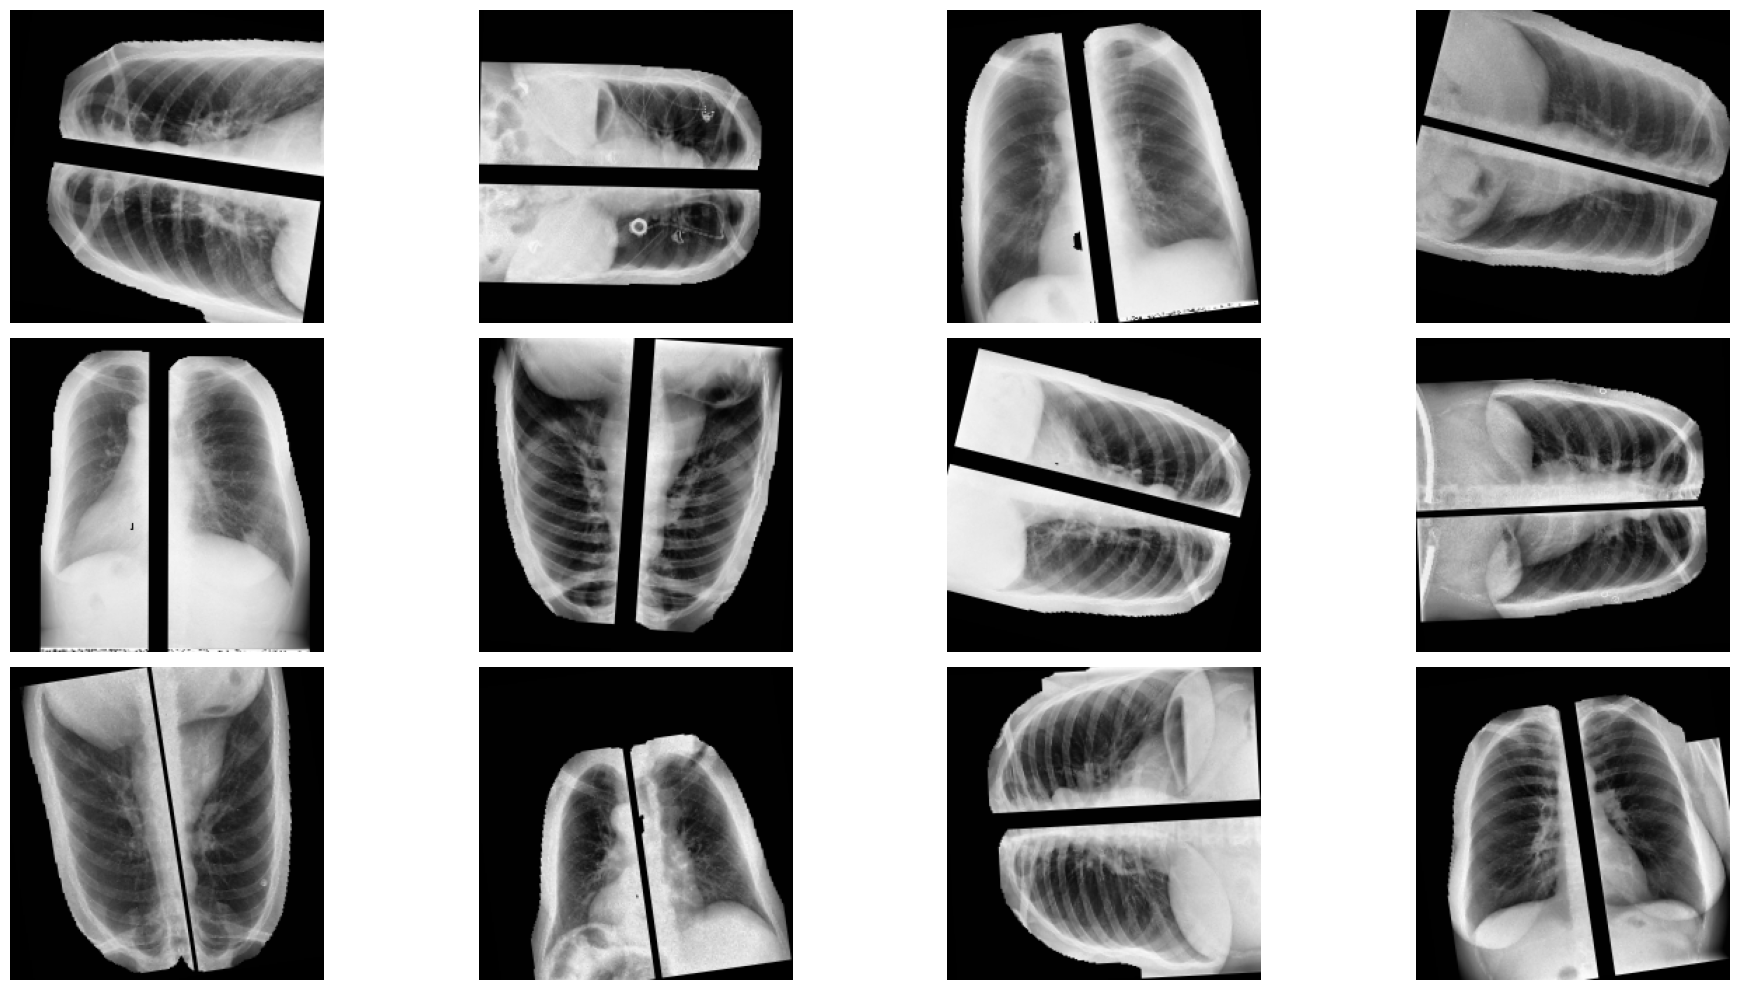

In [18]:
data, _ = dtrain.take(2)
images = data[0].numpy()
fig, axes = plt.subplots(3, 4, figsize=(20,10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [19]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_labels),
                                                  y=train_labels)

class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.7600198741305068, 1: 1.4614649681528662}

In [20]:
def build_model():
    base_model = DenseNet121(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    attention = layers.Dense(1024, activation='relu')(x)
    attention = layers.Dense(1024, activation='sigmoid')(attention)
    x = layers.Multiply()([x, attention])
    
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs=base_model.input, outputs=x)

model = build_model()
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=loss, metrics=[tf.keras.metrics.AUC()])

In [21]:
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, verbose = 1, min_delta = 1e-4, min_lr = 1e-7, mode = 'min', cooldown=1)
ckp = ModelCheckpoint(name, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 11, mode = 'min', restore_best_weights = True, verbose = 1)

callbacks_list = [rlr, ckp, es]
history = model.fit(dtrain,
                    validation_data=dvalid,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    steps_per_epoch=train_paths.shape[0]//BATCH_SIZE,
                    verbose=1,
                    class_weight=class_weights)

Epoch 1/100


I0000 00:00:1724841538.749984   79896 service.cc:145] XLA service 0x7f87fc001f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724841538.750049   79896 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-08-28 17:39:00.468861: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-28 17:39:05.339918: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1724841553.549951   79987 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_31115', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1724841554.012591   79985 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_35899', 40 bytes spill stores, 40 bytes spill loads

I00

143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - auc: 0.7171 - loss: 0.6247

I0000 00:00:1724841670.288699   80139 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3311', 260 bytes spill stores, 260 bytes spill loads

I0000 00:00:1724841670.875517   80136 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3304', 240 bytes spill stores, 240 bytes spill loads




Epoch 1: val_loss improved from inf to 0.66957, saving model to Segmentation_only_xrays_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 181s 336ms/step - auc: 0.7175 - loss: 0.6244 - val_auc: 0.7528 - val_loss: 0.6696 - learning_rate: 1.0000e-04
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - auc: 0.8276 - loss: 0.5130
Epoch 2: val_loss improved from 0.66957 to 0.54148, saving model to Segmentation_only_xrays_model.keras
143/143 ━━━━━━━━━━━━━━━━━━━━ 28s 199ms/step - auc: 0.8276 - loss: 0.5130 - val_auc: 0.8456 - val_loss: 0.5415 - learning_rate: 1.0000e-04
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - auc: 0.8579 - loss: 0.4681
Epoch 3: val_loss did not improve from 0.54148
143/143 ━━━━━━━━━━━━━━━━━━━━ 27s 192ms/step - auc: 0.8580 - loss: 0.4680 - val_auc: 0.7958 - val_loss: 0.8828 - learning_rate: 1.0000e-04
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - auc: 0.8739 - loss: 0.4463
Epoch 4: val_loss improved from 0.54148 to 0.46831, saving model to Segmentation_

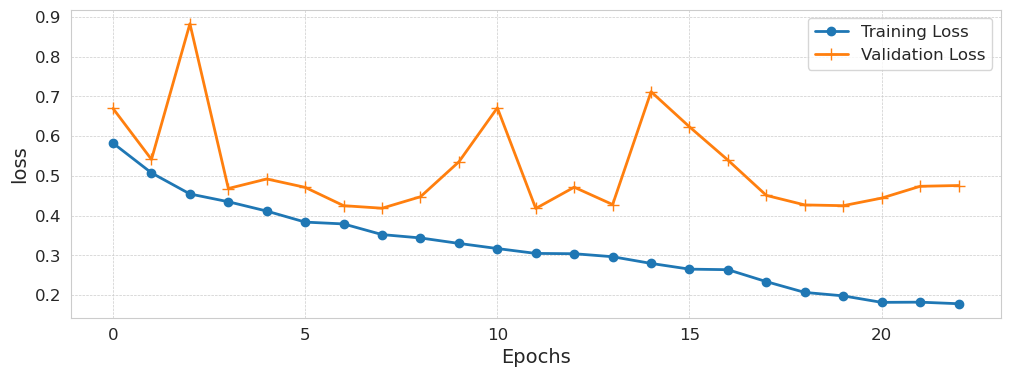

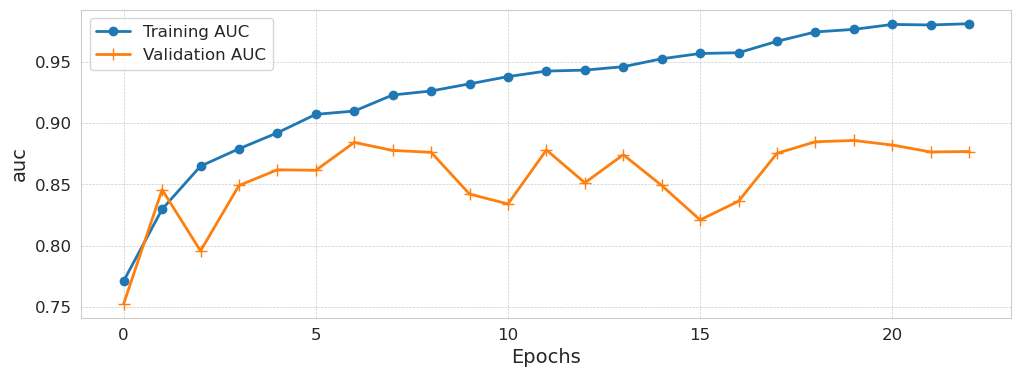

In [22]:
plot_loss_metrics(history, "loss", "auc", "Loss", "AUC")

36/36 ━━━━━━━━━━━━━━━━━━━━ 20s 354ms/step
AUC для Nodule/Mass
0.8778396534959783


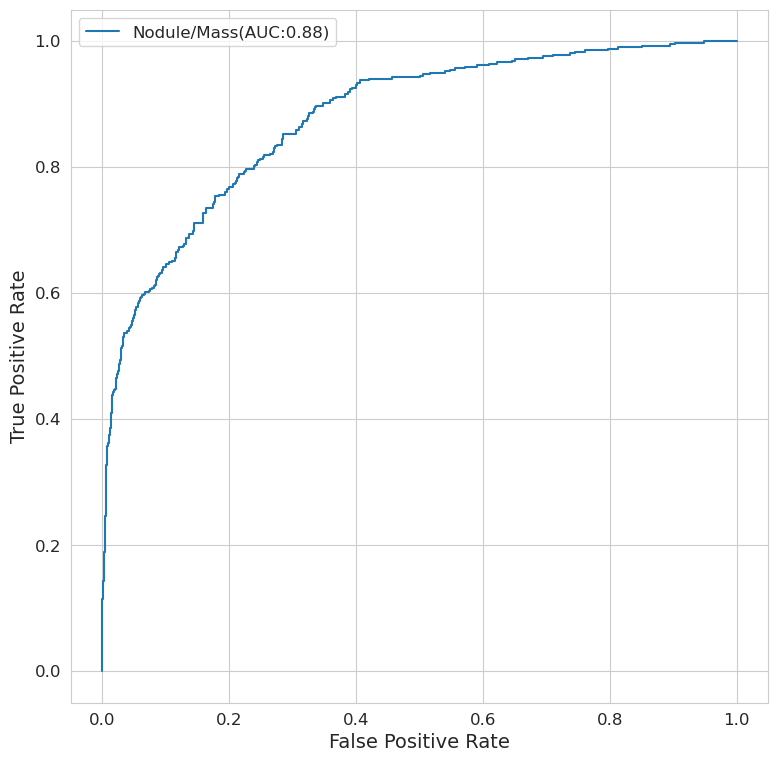

In [23]:
plot_roc_auc(name, dvalid, valid_labels)

## Обучение модели на сегментированных и обычных снимках

In [14]:
train_paths = train_df['path']
train_black = train_paths.apply(lambda x: '2k_TRAIN_SEGMENT_BLACK_DEL/' + x.split('/')[-1])
train_paths = np.concatenate([train_black, train_paths])
train_labels = np.concatenate([train_labels, train_labels])

In [15]:
train_paths.shape

(9178,)

In [16]:
train_labels.shape 

(9178,)

In [17]:
name = 'Segmentation_and_simple_xrays_model.keras'

decoder = build_decoder(with_labels=True, target_size=(IMG_SIZE, IMG_SIZE))
dtrain = build_dataset(train_paths, train_labels, batch_size=BATCH_SIZE, decode_fn=decoder, augment=True, repeat=True)
dvalid = build_dataset(valid_paths, valid_labels, batch_size=BATCH_SIZE, decode_fn=decoder, augment=False, repeat=False)

2024-08-28 18:13:57.071780: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-28 18:13:57.073102: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-28 18:13:57.073311: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

2024-08-28 18:13:57.723526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


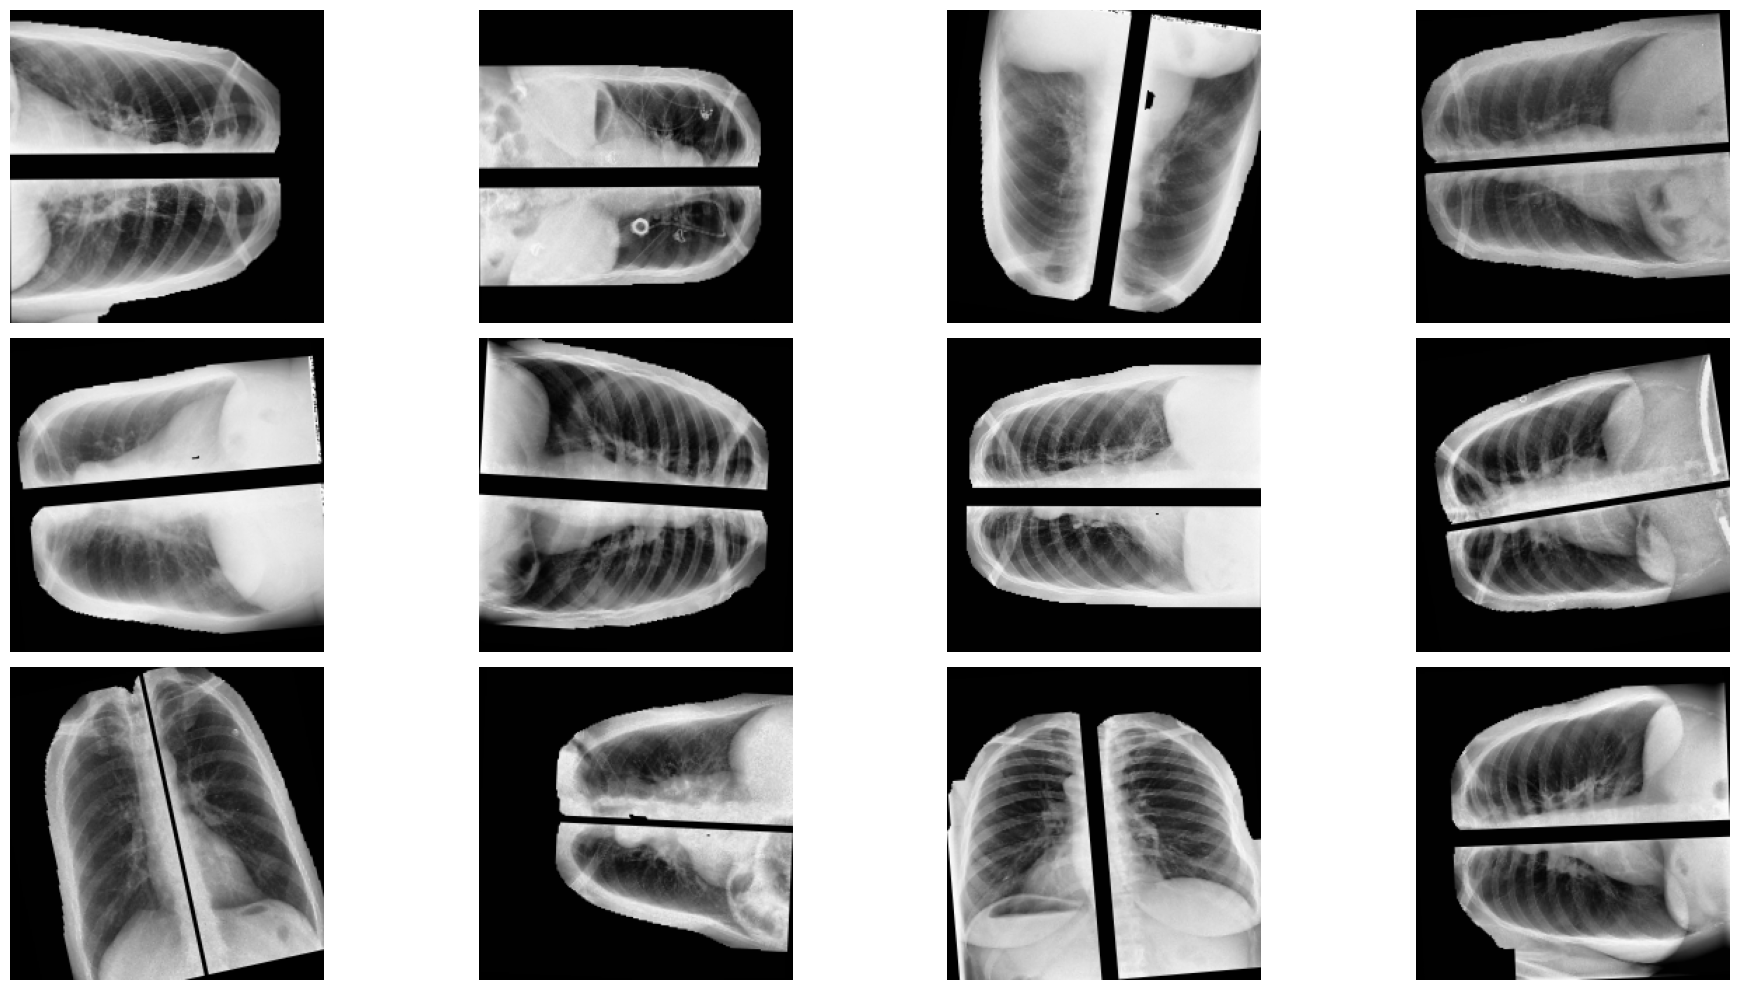

In [18]:
data, _ = dtrain.take(2)
images = data[0].numpy()
fig, axes = plt.subplots(3, 4, figsize=(20,10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [19]:
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_labels),
                                                  y=train_labels)

class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.7600198741305068, 1: 1.4614649681528662}

In [20]:
def build_model():
    base_model = DenseNet121(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)

    attention = layers.Dense(1024, activation='relu')(x)
    attention = layers.Dense(1024, activation='sigmoid')(attention)
    x = layers.Multiply()([x, attention])
    
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(1, activation='sigmoid')(x)

    return Model(inputs=base_model.input, outputs=x)

model = build_model()
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.0)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=loss, metrics=[tf.keras.metrics.AUC()])

In [21]:
rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5, verbose = 1, min_delta = 1e-4, min_lr = 1e-7, mode = 'min', cooldown=1)
ckp = ModelCheckpoint(name, monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'min')
es = EarlyStopping(monitor = 'val_loss', min_delta = 1e-4, patience = 11, mode = 'min', restore_best_weights = True, verbose = 1)

callbacks_list = [rlr, ckp, es]
history = model.fit(dtrain,
                    validation_data=dvalid,
                    epochs=EPOCHS,
                    callbacks=callbacks_list,
                    steps_per_epoch=train_paths.shape[0]//BATCH_SIZE,
                    verbose=1,
                    class_weight=class_weights)

Epoch 1/100


I0000 00:00:1724843683.912356   81392 service.cc:145] XLA service 0x7f01d4003de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724843683.912408   81392 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-08-28 18:14:45.588791: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-28 18:14:50.366872: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1724843698.781379   81481 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_31115', 192 bytes spill stores, 192 bytes spill loads

I0000 00:00:1724843699.141221   81482 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_31122', 192 bytes spill stores, 192 bytes spill loads

I

186/286 ━━━━━━━━━━━━━━━━━━━━ 17s 171ms/step - auc: 0.7384 - loss: 0.6051

2024-08-28 18:16:52.671623: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - auc: 0.7563 - loss: 0.5890

I0000 00:00:1724843852.137811   81670 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3304', 240 bytes spill stores, 240 bytes spill loads

I0000 00:00:1724843852.738645   81663 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_3311', 260 bytes spill stores, 260 bytes spill loads




Epoch 1: val_loss improved from inf to 0.96258, saving model to Segmentation_and_simple_xrays_model.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 219s 292ms/step - auc: 0.7564 - loss: 0.5889 - val_auc: 0.7938 - val_loss: 0.9626 - learning_rate: 1.0000e-04
Epoch 2/100
187/286 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - auc: 0.8502 - loss: 0.4792

2024-08-28 18:18:15.544968: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - auc: 0.8529 - loss: 0.4751
Epoch 2: val_loss improved from 0.96258 to 0.49873, saving model to Segmentation_and_simple_xrays_model.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 63s 219ms/step - auc: 0.8529 - loss: 0.4751 - val_auc: 0.8514 - val_loss: 0.4987 - learning_rate: 1.0000e-04
Epoch 3/100
188/286 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - auc: 0.8725 - loss: 0.4464

2024-08-28 18:19:17.881739: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - auc: 0.8770 - loss: 0.4386
Epoch 3: val_loss improved from 0.49873 to 0.42673, saving model to Segmentation_and_simple_xrays_model.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 63s 220ms/step - auc: 0.8771 - loss: 0.4385 - val_auc: 0.8704 - val_loss: 0.4267 - learning_rate: 1.0000e-04
Epoch 4/100
184/286 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - auc: 0.8913 - loss: 0.4151

2024-08-28 18:20:19.118372: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - auc: 0.8955 - loss: 0.4069
Epoch 4: val_loss did not improve from 0.42673
286/286 ━━━━━━━━━━━━━━━━━━━━ 61s 215ms/step - auc: 0.8956 - loss: 0.4069 - val_auc: 0.8666 - val_loss: 0.4509 - learning_rate: 1.0000e-04
Epoch 5/100
160/286 ━━━━━━━━━━━━━━━━━━━━ 20s 161ms/step - auc: 0.9090 - loss: 0.3835

2024-08-28 18:21:16.592245: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - auc: 0.9106 - loss: 0.3789
Epoch 5: val_loss did not improve from 0.42673
286/286 ━━━━━━━━━━━━━━━━━━━━ 58s 204ms/step - auc: 0.9106 - loss: 0.3789 - val_auc: 0.8782 - val_loss: 0.5255 - learning_rate: 1.0000e-04
Epoch 6/100
156/286 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - auc: 0.9157 - loss: 0.3655

2024-08-28 18:22:14.047888: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - auc: 0.9178 - loss: 0.3615
Epoch 6: val_loss improved from 0.42673 to 0.40727, saving model to Segmentation_and_simple_xrays_model.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 61s 215ms/step - auc: 0.9179 - loss: 0.3614 - val_auc: 0.8837 - val_loss: 0.4073 - learning_rate: 1.0000e-04
Epoch 7/100
 83/286 ━━━━━━━━━━━━━━━━━━━━ 32s 162ms/step - auc: 0.9231 - loss: 0.3513

2024-08-28 18:23:03.922011: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - auc: 0.9293 - loss: 0.3370
Epoch 7: val_loss improved from 0.40727 to 0.39407, saving model to Segmentation_and_simple_xrays_model.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 58s 202ms/step - auc: 0.9293 - loss: 0.3370 - val_auc: 0.9025 - val_loss: 0.3941 - learning_rate: 1.0000e-04
Epoch 8/100
 48/286 ━━━━━━━━━━━━━━━━━━━━ 38s 162ms/step - auc: 0.9380 - loss: 0.3198

2024-08-28 18:23:56.089991: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - auc: 0.9360 - loss: 0.3223
Epoch 8: val_loss improved from 0.39407 to 0.37439, saving model to Segmentation_and_simple_xrays_model.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 54s 190ms/step - auc: 0.9360 - loss: 0.3223 - val_auc: 0.9039 - val_loss: 0.3744 - learning_rate: 1.0000e-04
Epoch 9/100
 65/286 ━━━━━━━━━━━━━━━━━━━━ 35s 163ms/step - auc: 0.9360 - loss: 0.3238

2024-08-28 18:24:53.334631: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - auc: 0.9412 - loss: 0.3096
Epoch 9: val_loss did not improve from 0.37439
286/286 ━━━━━━━━━━━━━━━━━━━━ 53s 187ms/step - auc: 0.9412 - loss: 0.3096 - val_auc: 0.8965 - val_loss: 0.4940 - learning_rate: 1.0000e-04
Epoch 10/100
 86/286 ━━━━━━━━━━━━━━━━━━━━ 32s 162ms/step - auc: 0.9520 - loss: 0.2840

2024-08-28 18:25:50.112750: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - auc: 0.9493 - loss: 0.2889
Epoch 10: val_loss did not improve from 0.37439
286/286 ━━━━━━━━━━━━━━━━━━━━ 56s 197ms/step - auc: 0.9493 - loss: 0.2889 - val_auc: 0.8900 - val_loss: 0.4349 - learning_rate: 1.0000e-04
Epoch 11/100
 58/286 ━━━━━━━━━━━━━━━━━━━━ 37s 162ms/step - auc: 0.9554 - loss: 0.2697

2024-08-28 18:26:42.135090: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - auc: 0.9551 - loss: 0.2709
Epoch 11: val_loss did not improve from 0.37439
286/286 ━━━━━━━━━━━━━━━━━━━━ 54s 190ms/step - auc: 0.9551 - loss: 0.2710 - val_auc: 0.9046 - val_loss: 0.3751 - learning_rate: 1.0000e-04
Epoch 12/100
 75/286 ━━━━━━━━━━━━━━━━━━━━ 34s 161ms/step - auc: 0.9630 - loss: 0.2474

2024-08-28 18:27:39.144269: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - auc: 0.9598 - loss: 0.2570
Epoch 12: val_loss did not improve from 0.37439
286/286 ━━━━━━━━━━━━━━━━━━━━ 54s 187ms/step - auc: 0.9598 - loss: 0.2570 - val_auc: 0.9223 - val_loss: 0.3776 - learning_rate: 1.0000e-04
Epoch 13/100
 95/286 ━━━━━━━━━━━━━━━━━━━━ 30s 161ms/step - auc: 0.9628 - loss: 0.2471

2024-08-28 18:28:36.057323: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - auc: 0.9625 - loss: 0.2481
Epoch 13: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 13: val_loss did not improve from 0.37439
286/286 ━━━━━━━━━━━━━━━━━━━━ 56s 198ms/step - auc: 0.9625 - loss: 0.2481 - val_auc: 0.9074 - val_loss: 0.3839 - learning_rate: 1.0000e-04
Epoch 14/100
 65/286 ━━━━━━━━━━━━━━━━━━━━ 35s 159ms/step - auc: 0.9661 - loss: 0.2351

2024-08-28 18:29:27.497926: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - auc: 0.9701 - loss: 0.2217
Epoch 14: val_loss did not improve from 0.37439
286/286 ━━━━━━━━━━━━━━━━━━━━ 56s 196ms/step - auc: 0.9701 - loss: 0.2217 - val_auc: 0.9234 - val_loss: 0.3887 - learning_rate: 1.0000e-05
Epoch 15/100
 55/286 ━━━━━━━━━━━━━━━━━━━━ 37s 162ms/step - auc: 0.9771 - loss: 0.1958

2024-08-28 18:30:22.032434: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - auc: 0.9790 - loss: 0.1868
Epoch 15: val_loss did not improve from 0.37439
286/286 ━━━━━━━━━━━━━━━━━━━━ 56s 197ms/step - auc: 0.9790 - loss: 0.1868 - val_auc: 0.9244 - val_loss: 0.4126 - learning_rate: 1.0000e-05
Epoch 16/100
 66/286 ━━━━━━━━━━━━━━━━━━━━ 35s 161ms/step - auc: 0.9818 - loss: 0.1752

2024-08-28 18:31:20.093224: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - auc: 0.9835 - loss: 0.1663
Epoch 16: val_loss did not improve from 0.37439
286/286 ━━━━━━━━━━━━━━━━━━━━ 53s 184ms/step - auc: 0.9835 - loss: 0.1662 - val_auc: 0.9238 - val_loss: 0.3822 - learning_rate: 1.0000e-05
Epoch 17/100
 95/286 ━━━━━━━━━━━━━━━━━━━━ 30s 161ms/step - auc: 0.9854 - loss: 0.1591

2024-08-28 18:32:17.444917: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - auc: 0.9854 - loss: 0.1570
Epoch 17: val_loss improved from 0.37439 to 0.37052, saving model to Segmentation_and_simple_xrays_model.keras
286/286 ━━━━━━━━━━━━━━━━━━━━ 58s 202ms/step - auc: 0.9854 - loss: 0.1570 - val_auc: 0.9283 - val_loss: 0.3705 - learning_rate: 1.0000e-05
Epoch 18/100
 49/286 ━━━━━━━━━━━━━━━━━━━━ 39s 168ms/step - auc: 0.9758 - loss: 0.2000

2024-08-28 18:33:08.201866: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - auc: 0.9816 - loss: 0.1729
Epoch 18: val_loss did not improve from 0.37052
286/286 ━━━━━━━━━━━━━━━━━━━━ 57s 200ms/step - auc: 0.9816 - loss: 0.1729 - val_auc: 0.9193 - val_loss: 0.4087 - learning_rate: 1.0000e-05
Epoch 19/100
 52/286 ━━━━━━━━━━━━━━━━━━━━ 37s 159ms/step - auc: 0.9843 - loss: 0.1623

2024-08-28 18:34:05.314604: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - auc: 0.9860 - loss: 0.1525
Epoch 19: val_loss did not improve from 0.37052
286/286 ━━━━━━━━━━━━━━━━━━━━ 56s 196ms/step - auc: 0.9860 - loss: 0.1524 - val_auc: 0.9226 - val_loss: 0.4061 - learning_rate: 1.0000e-05
Epoch 20/100
 50/286 ━━━━━━━━━━━━━━━━━━━━ 37s 161ms/step - auc: 0.9841 - loss: 0.1592

2024-08-28 18:35:01.196171: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - auc: 0.9865 - loss: 0.1483
Epoch 20: val_loss did not improve from 0.37052
286/286 ━━━━━━━━━━━━━━━━━━━━ 53s 185ms/step - auc: 0.9865 - loss: 0.1483 - val_auc: 0.9243 - val_loss: 0.4019 - learning_rate: 1.0000e-05
Epoch 21/100
 78/286 ━━━━━━━━━━━━━━━━━━━━ 33s 161ms/step - auc: 0.9879 - loss: 0.1426

2024-08-28 18:35:58.665703: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - auc: 0.9897 - loss: 0.1307
Epoch 21: val_loss did not improve from 0.37052
286/286 ━━━━━━━━━━━━━━━━━━━━ 53s 185ms/step - auc: 0.9897 - loss: 0.1307 - val_auc: 0.9171 - val_loss: 0.4380 - learning_rate: 1.0000e-05
Epoch 22/100
110/286 ━━━━━━━━━━━━━━━━━━━━ 27s 159ms/step - auc: 0.9882 - loss: 0.1358

2024-08-28 18:36:56.395891: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - auc: 0.9895 - loss: 0.1287
Epoch 22: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 22: val_loss did not improve from 0.37052
286/286 ━━━━━━━━━━━━━━━━━━━━ 56s 196ms/step - auc: 0.9895 - loss: 0.1287 - val_auc: 0.9212 - val_loss: 0.4256 - learning_rate: 1.0000e-05
Epoch 23/100
 66/286 ━━━━━━━━━━━━━━━━━━━━ 35s 160ms/step - auc: 0.9911 - loss: 0.1240

2024-08-28 18:37:45.477456: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - auc: 0.9914 - loss: 0.1190
Epoch 23: val_loss did not improve from 0.37052
286/286 ━━━━━━━━━━━━━━━━━━━━ 53s 185ms/step - auc: 0.9914 - loss: 0.1190 - val_auc: 0.9194 - val_loss: 0.4381 - learning_rate: 1.0000e-06
Epoch 24/100
 90/286 ━━━━━━━━━━━━━━━━━━━━ 31s 162ms/step - auc: 0.9894 - loss: 0.1306

2024-08-28 18:38:42.296487: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - auc: 0.9914 - loss: 0.1193
Epoch 24: val_loss did not improve from 0.37052
286/286 ━━━━━━━━━━━━━━━━━━━━ 57s 198ms/step - auc: 0.9914 - loss: 0.1193 - val_auc: 0.9207 - val_loss: 0.4380 - learning_rate: 1.0000e-06
Epoch 25/100
 60/286 ━━━━━━━━━━━━━━━━━━━━ 35s 159ms/step - auc: 0.9930 - loss: 0.1114

2024-08-28 18:39:33.926485: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - auc: 0.9926 - loss: 0.1123
Epoch 25: val_loss did not improve from 0.37052
286/286 ━━━━━━━━━━━━━━━━━━━━ 56s 197ms/step - auc: 0.9926 - loss: 0.1123 - val_auc: 0.9195 - val_loss: 0.4392 - learning_rate: 1.0000e-06
Epoch 26/100
 51/286 ━━━━━━━━━━━━━━━━━━━━ 37s 161ms/step - auc: 0.9867 - loss: 0.1473

2024-08-28 18:40:29.002706: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - auc: 0.9907 - loss: 0.1230
Epoch 26: val_loss did not improve from 0.37052
286/286 ━━━━━━━━━━━━━━━━━━━━ 56s 197ms/step - auc: 0.9907 - loss: 0.1230 - val_auc: 0.9213 - val_loss: 0.4377 - learning_rate: 1.0000e-06
Epoch 27/100
 52/286 ━━━━━━━━━━━━━━━━━━━━ 37s 159ms/step - auc: 0.9917 - loss: 0.1182

2024-08-28 18:41:25.207597: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - auc: 0.9925 - loss: 0.1117
Epoch 27: ReduceLROnPlateau reducing learning rate to 1e-07.

Epoch 27: val_loss did not improve from 0.37052
286/286 ━━━━━━━━━━━━━━━━━━━━ 56s 195ms/step - auc: 0.9925 - loss: 0.1118 - val_auc: 0.9209 - val_loss: 0.4347 - learning_rate: 1.0000e-06
Epoch 28/100
 51/286 ━━━━━━━━━━━━━━━━━━━━ 37s 160ms/step - auc: 0.9907 - loss: 0.1243

2024-08-28 18:42:21.061940: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: profile 'ICC Profile': 'GRAY': Gray color space not permitted on RGB PNG


286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - auc: 0.9922 - loss: 0.1128
Epoch 28: val_loss did not improve from 0.37052
286/286 ━━━━━━━━━━━━━━━━━━━━ 56s 196ms/step - auc: 0.9922 - loss: 0.1128 - val_auc: 0.9212 - val_loss: 0.4336 - learning_rate: 1.0000e-07
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 17.


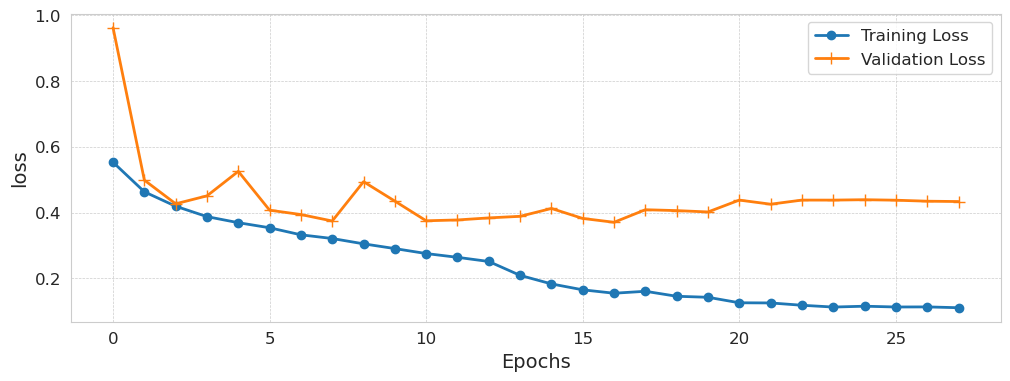

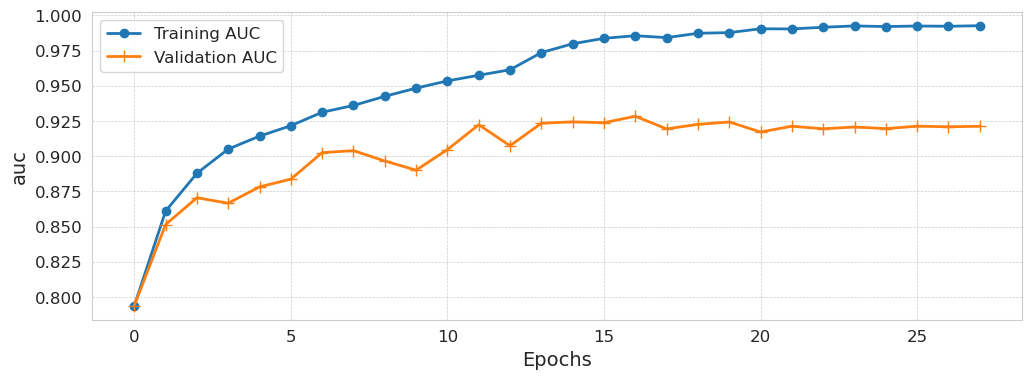

In [22]:
plot_loss_metrics(history, "loss", "auc", "Loss", "AUC")

36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 299ms/step
AUC для Nodule/Mass
0.9319923653875744


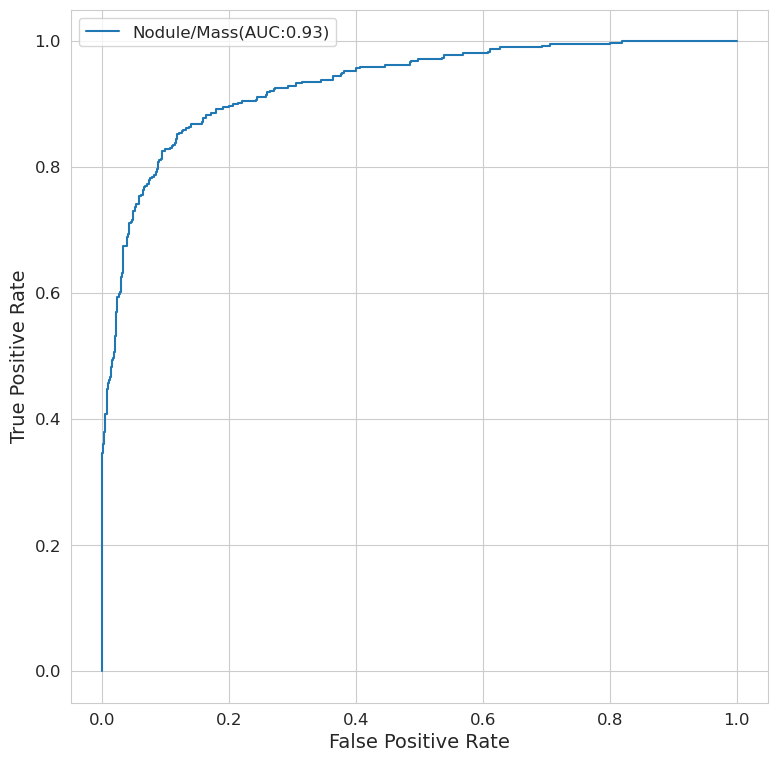

In [23]:
plot_roc_auc(name, dvalid, valid_labels)

# Сравнение подходов

In [24]:
tf.keras.backend.clear_session()

model1 = tf.keras.models.load_model("Correctly_data_model.keras")
pred1 = model1.predict(dvalid, verbose=1)

model2 = tf.keras.models.load_model("Segmentation_and_simple_xrays_model.keras")
pred2 = model2.predict(dvalid, verbose=1)

model3 = tf.keras.models.load_model("Segmentation_only_xrays_model.keras")
pred3 = model3.predict(dvalid, verbose=1)

36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 266ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 274ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 17s 279ms/step


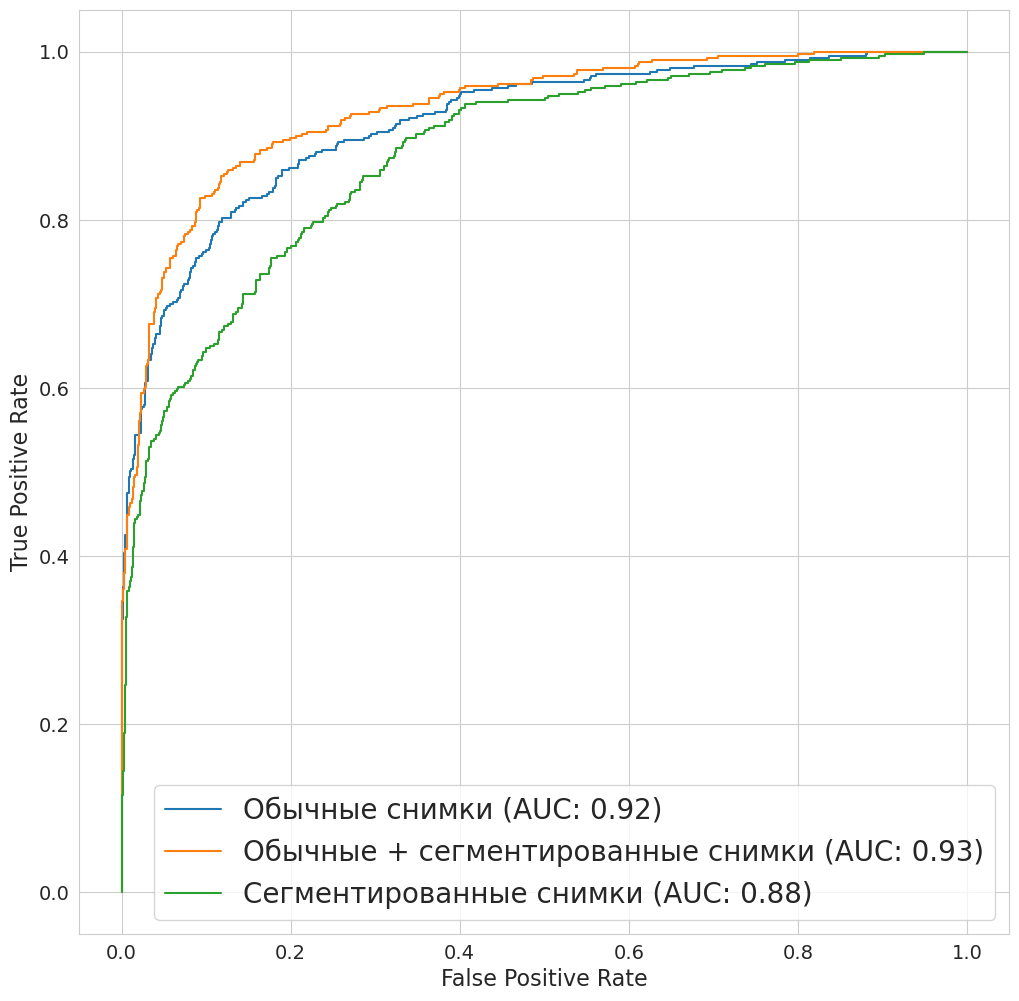

In [25]:
fig, c_ax = plt.subplots(1, 1, figsize=(12, 12))

fpr1, tpr1, thresholds1 = roc_curve(valid_labels, pred1)
c_ax.plot(fpr1, tpr1, label=f'Обычные снимки (AUC: {roc_auc_score(valid_labels, pred1):.2f})')

fpr2, tpr2, thresholds2 = roc_curve(valid_labels, pred2)
c_ax.plot(fpr2, tpr2, label=f'Обычные + сегментированные снимки (AUC: {roc_auc_score(valid_labels, pred2):.2f})')

fpr3, tpr3, thresholds3 = roc_curve(valid_labels, pred3)
c_ax.plot(fpr3, tpr3, label=f'Сегментированные снимки (AUC: {roc_auc_score(valid_labels, pred3):.2f})')

c_ax.legend(fontsize=20)
c_ax.set_xlabel('False Positive Rate', fontsize=16)
c_ax.set_ylabel('True Positive Rate', fontsize=16)
c_ax.tick_params(axis='both', which='major', labelsize=14)
fig.savefig("Сравнение_моделей_2_ROC_AUC.png")
plt.show()

# Bbox и тепловые карты

In [26]:
def get_img_array(img_path, size):
    img = keras_image.load_img(img_path, target_size=size)
    array = keras_image.img_to_array(img)
    array /= 255.0
    return array

In [27]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [28]:
def display_gradcam(img_path, heatmap, alpha=0.4):
    img = keras_image.load_img(img_path)
    img = keras_image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras_image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras_image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras_image.array_to_img(superimposed_img)

    display(superimposed_img)

In [29]:
def count_activation_pixels(heatmap, mask):
    heatmap_flat = heatmap.flatten()
    mask_flat = mask.flatten()

    # Подсчет активации пикселей внутри маски
    inside_mask = np.sum(heatmap_flat[mask_flat == 1])

    # Подсчет активации пикселей вне маски
    outside_mask = np.sum(heatmap_flat[mask_flat == 0])

    # Нормализация значений
    total_activation = inside_mask + outside_mask
    inside_mask /= total_activation
    outside_mask /= total_activation

    return inside_mask, outside_mask

In [30]:
def get_bbox_mask(img_path, bbox_data):
    img_name = img_path.split('/')[-1]
    bbox_info = bbox_data[bbox_data['img_name'] == img_name]
    bbox_mask = np.zeros((224, 224))
    
    for _, row in bbox_info.iterrows():
        x, y, w, h = row['x'], row['y'], row['width'], row['height']
        x = int(x * 224 / 1024)
        y = int(y * 224 / 1024)
        w = int(w * 224 / 1024)
        h = int(h * 224 / 1024)
        
        bbox_mask[y:y+h, x:x+w] = 1
    
    return bbox_mask

## Модель без сегментации

In [31]:
name = 'Correctly_data_model.keras'
model_grad = tf.keras.models.load_model(name)
model_grad_prob = tf.keras.models.load_model(name)

img_size = (224, 224)
last_conv_layer_name = "conv5_block16_concat"
model_grad.layers[-1].activation = None    

In [32]:
bbox_data = pd.read_csv('More Bbox Nodule/CXR.v1-chestx-ray_zhangjin_kaggle.tensorflow/transformed_combined.csv')
img_folder_path = 'More Bbox Nodule/merge/'
activation_results = []
img_files = [f for f in os.listdir(img_folder_path) if f.lower().endswith(('.png'))]

for img_name in tqdm(img_files, desc='Обработка изображений'):
    img_path = os.path.join(img_folder_path, img_name)
    
    img_array = get_img_array(img_path, size=(224, 224))
    img_array = np.expand_dims(img_array, axis=0)
    
    heatmap = make_gradcam_heatmap(img_array, model_grad, last_conv_layer_name)
    heatmap = heatmap.astype('float32')
    heatmap_resized = cv2.resize(heatmap, (224, 224), interpolation=cv2.INTER_NEAREST)
    
    # Получение маски BBox для изображения
    bbox_mask = get_bbox_mask(img_path, bbox_data)
    
    # Подсчет активаций внутри и вне BBox
    inside_bbox, _ = count_activation_pixels(heatmap_resized, bbox_mask)
    
    # Добавление результатов в список
    activation_results.append({'img_name': img_name, 'inside_bbox_activation': inside_bbox * 100})

activation_df = pd.DataFrame(activation_results)
activation_df.to_csv('activation_results_Correctly_data_model.keras.csv', index=False)

Обработка изображений: 100%|██████████| 1650/1650 [17:15<00:00,  1.59it/s]


In [33]:
data = pd.read_csv('activation_results_Correctly_data_model.keras.csv')
zero_count = (data['inside_bbox_activation'] == 0).sum()
missing_count = data['inside_bbox_activation'].isnull().sum()

print(f"Количество значений с 0: {zero_count}")
print(f"Количество пропусков: {missing_count}")

Количество значений с 0: 99
Количество пропусков: 0


## Модель с сегментацией

In [34]:
name = 'Segmentation_and_simple_xrays_model.keras'
model_grad = tf.keras.models.load_model(name)
model_grad_prob = tf.keras.models.load_model(name)

img_size = (224, 224)
last_conv_layer_name = "conv5_block16_concat"
model_grad.layers[-1].activation = None    

In [35]:
bbox_data = pd.read_csv('More Bbox Nodule/CXR.v1-chestx-ray_zhangjin_kaggle.tensorflow/transformed_combined.csv')
img_folder_path = 'More Bbox Nodule/merge/'
activation_results = []
img_files = [f for f in os.listdir(img_folder_path) if f.lower().endswith(('.png'))]

for img_name in tqdm(img_files, desc='Обработка изображений'):
    img_path = os.path.join(img_folder_path, img_name)
    
    img_array = get_img_array(img_path, size=(224, 224))
    img_array = np.expand_dims(img_array, axis=0)
    
    heatmap = make_gradcam_heatmap(img_array, model_grad, last_conv_layer_name)
    heatmap = heatmap.astype('float32')
    heatmap_resized = cv2.resize(heatmap, (224, 224), interpolation=cv2.INTER_NEAREST)
    
    # Получение маски BBox для изображения
    bbox_mask = get_bbox_mask(img_path, bbox_data)
    
    # Подсчет активаций внутри и вне BBox
    inside_bbox, _ = count_activation_pixels(heatmap_resized, bbox_mask)
    
    # Добавление результатов в список
    activation_results.append({'img_name': img_name, 'inside_bbox_activation': inside_bbox * 100})

activation_df = pd.DataFrame(activation_results)
activation_df.to_csv('activation_results_Segmentation_and_simple_xrays_model.keras.csv', index=False)

Обработка изображений:  34%|███▍      | 565/1650 [06:00<11:28,  1.57it/s]/tmp/ipykernel_81298/1752783504.py:13: RuntimeWarning: invalid value encountered in scalar divide
  inside_mask /= total_activation
/tmp/ipykernel_81298/1752783504.py:14: RuntimeWarning: invalid value encountered in scalar divide
  outside_mask /= total_activation
Обработка изображений: 100%|██████████| 1650/1650 [17:14<00:00,  1.59it/s]


In [36]:
data = pd.read_csv('activation_results_Segmentation_and_simple_xrays_model.keras.csv')
zero_count = (data['inside_bbox_activation'] == 0).sum()
missing_count = data['inside_bbox_activation'].isnull().sum()

print(f"Количество значений с 0: {zero_count}")
print(f"Количество пропусков: {missing_count}")

Количество значений с 0: 121
Количество пропусков: 5


## Сравнение

In [39]:
data1 = pd.read_csv('activation_results_Segmentation_and_simple_xrays_model.keras.csv')
data2 = pd.read_csv('activation_results_Correctly_data_model.keras.csv')

data1 = data1.sort_values('img_name').reset_index(drop=True)
data2 = data2.sort_values('img_name').reset_index(drop=True)

count = (data1['inside_bbox_activation'] >= data2['inside_bbox_activation']).sum()
total = len(data1)
percentage = (count / total) * 100

print(f"Количество случаев, когда значения активаций больше с сегментацией: {count}")
print(f"Процент случаев, когда значения активаций больше с сегментацией: {percentage:.2f}%")

Количество случаев, когда значения активаций больше с сегментацией: 1115
Процент случаев, когда значения активаций больше с сегментацией: 67.58%
